<a target="_blank" rel="noopener noreferrer" href="https://colab.research.google.com/github/ccaudek/ds4psy_2023/blob/main/42_hier_gaussian.ipynb">![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)</a>

(hier_gaussian_model)=
# Modello gerarchico gaussiano

In questo capitolo, proseguiremo la discussione sul modello gerarchico bayesiano utilizzando PyMC, concentrandoci questa volta sul caso in cui i dati seguono una distribuzione di gaussiana.

In questo capitolo, esamineremo il modello gerarchico gaussiano utilizzando i dati forniti da {cite:t}`McElreath_rethinking`. Questi dati rappresentano le valutazioni di 20 diversi vini francesi e americani effettuate da 9 giudici. L'obiettivo è modellare il punteggio, ovvero la valutazione soggettiva assegnata ai vini da ciascun giudice. Ci si chiede, in particolare, di descrivere le variazioni individuali nei giudizi dei giudici. {cite:t}`McElreath_rethinking` consiglia di standardizzare i dati preliminarmente all'analisi. 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import pymc.sampling_jax
import bambi as bmb
import scipy.stats as stats
from scipy.stats import gaussian_kde
from sklearn.preprocessing import scale
import arviz as az
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

/Users/corrado/mambaforge/envs/pymc5_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
%config InlineBackend.figure_format = 'retina'

RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)

from aquarel import load_theme
theme = load_theme("minimal_light")
theme.apply()
sns.set_palette("colorblind")

## Preparazione del notebook


In [4]:
wines = pd.read_csv("../data/Wines2012.csv", sep=";")
print(wines.head())

             judge flight wine  score  wine.amer  judge.amer
0  Jean-M Cardebat  white   A1   10.0          1           0
1  Jean-M Cardebat  white   B1   13.0          1           0
2  Jean-M Cardebat  white   C1   14.0          0           0
3  Jean-M Cardebat  white   D1   15.0          0           0
4  Jean-M Cardebat  white   E1    8.0          1           0


In [4]:
wines.shape

(180, 6)

Nove giudici hanno effettuato una valutazione individuale su un totale di 20 vini ciascuno.

In [5]:
wines.value_counts("judge")

judge
Daniele Meulder    20
Francis Schott     20
Jamal Rayyis       20
Jean-M Cardebat    20
John Foy           20
Linda Murphy       20
Olivier Gergaud    20
Robert Hodgson     20
Tyler Colman       20
Name: count, dtype: int64

Creiamo una variabile categoriale che assegna un giudice a ciascuno dei 180 giudizi.

In [7]:
J = wines['judge'].astype('category')
J.cat.codes

0      3
1      3
2      3
3      3
4      3
      ..
175    1
176    1
177    1
178    1
179    1
Length: 180, dtype: int8

In [8]:
J.cat.codes.nunique()

9

Creiamo un istogramma che rappresenti le frequenze assolute ignorando la suddivisione tra i diversi giudici.

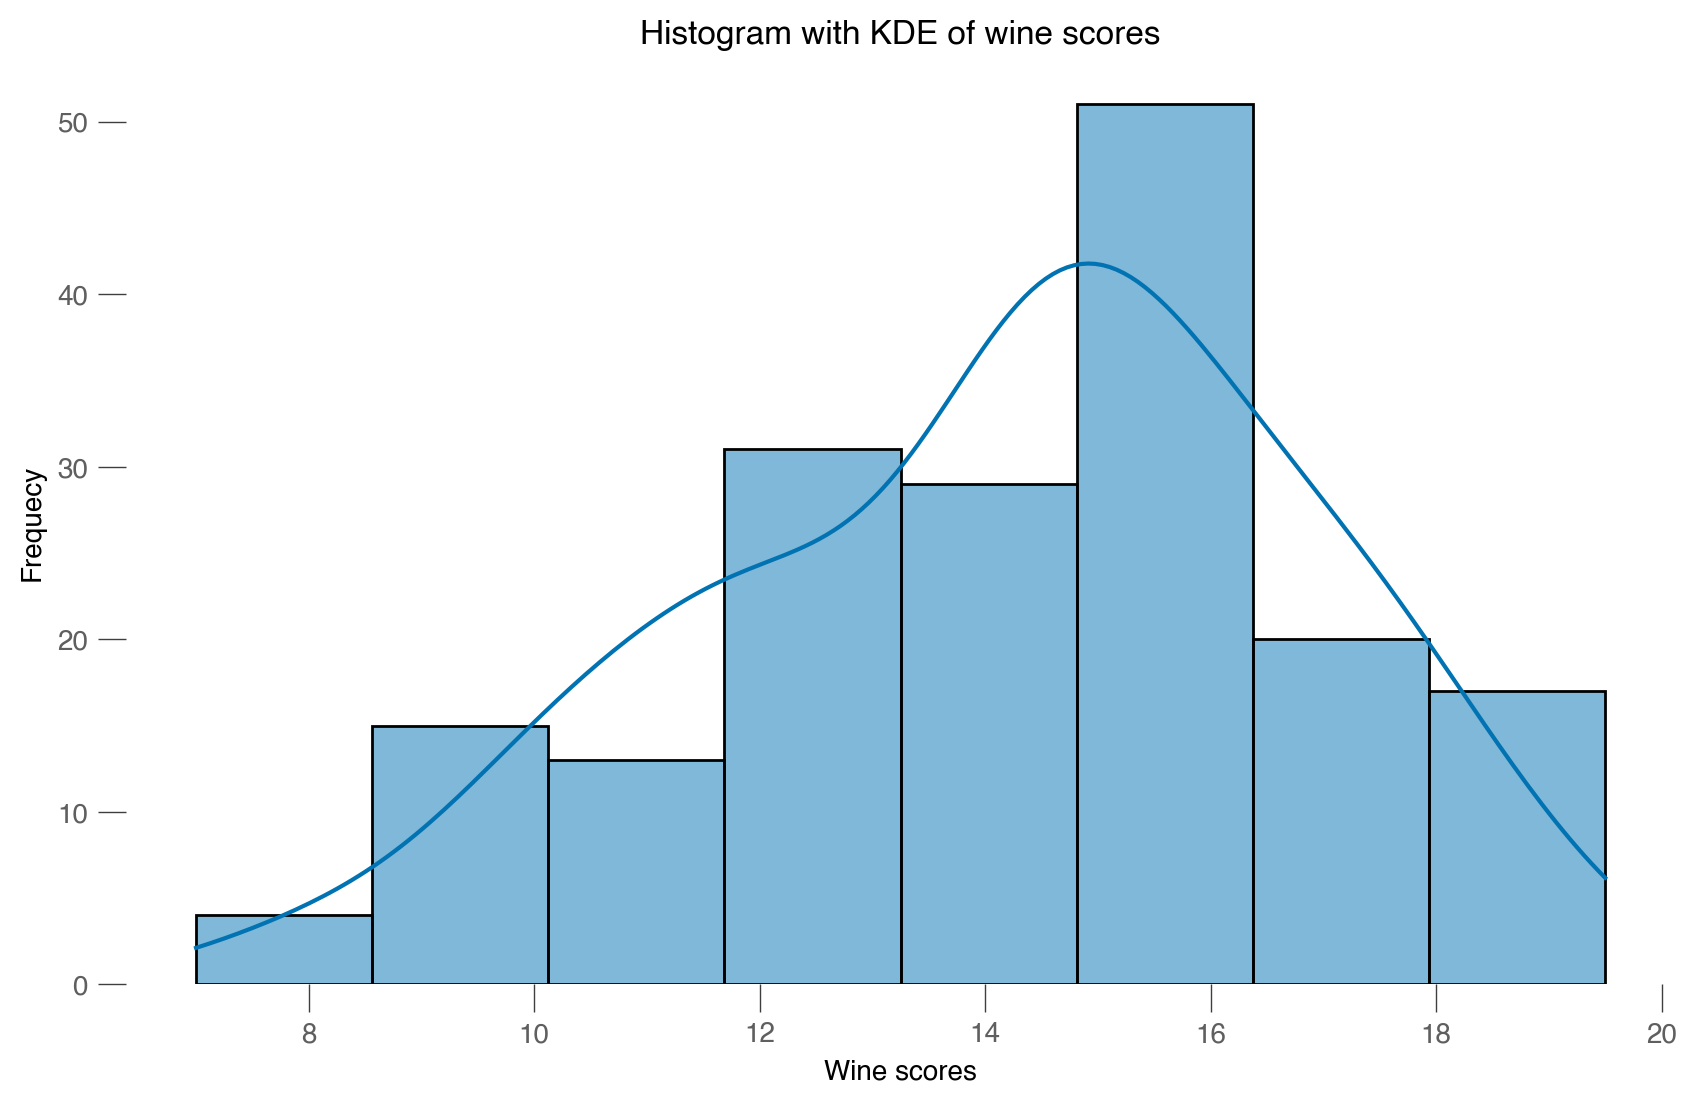

In [10]:
sns.histplot(data=wines, x="score", bins=8, kde=True)
plt.xlabel("Wine scores")
plt.ylabel("Frequecy")
plt.title("Histogram with KDE of wine scores");

Esaminiamo gli istogrammi separatamente per ciascun giudice.

/Users/corrado/mambaforge/envs/pymc5_env/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


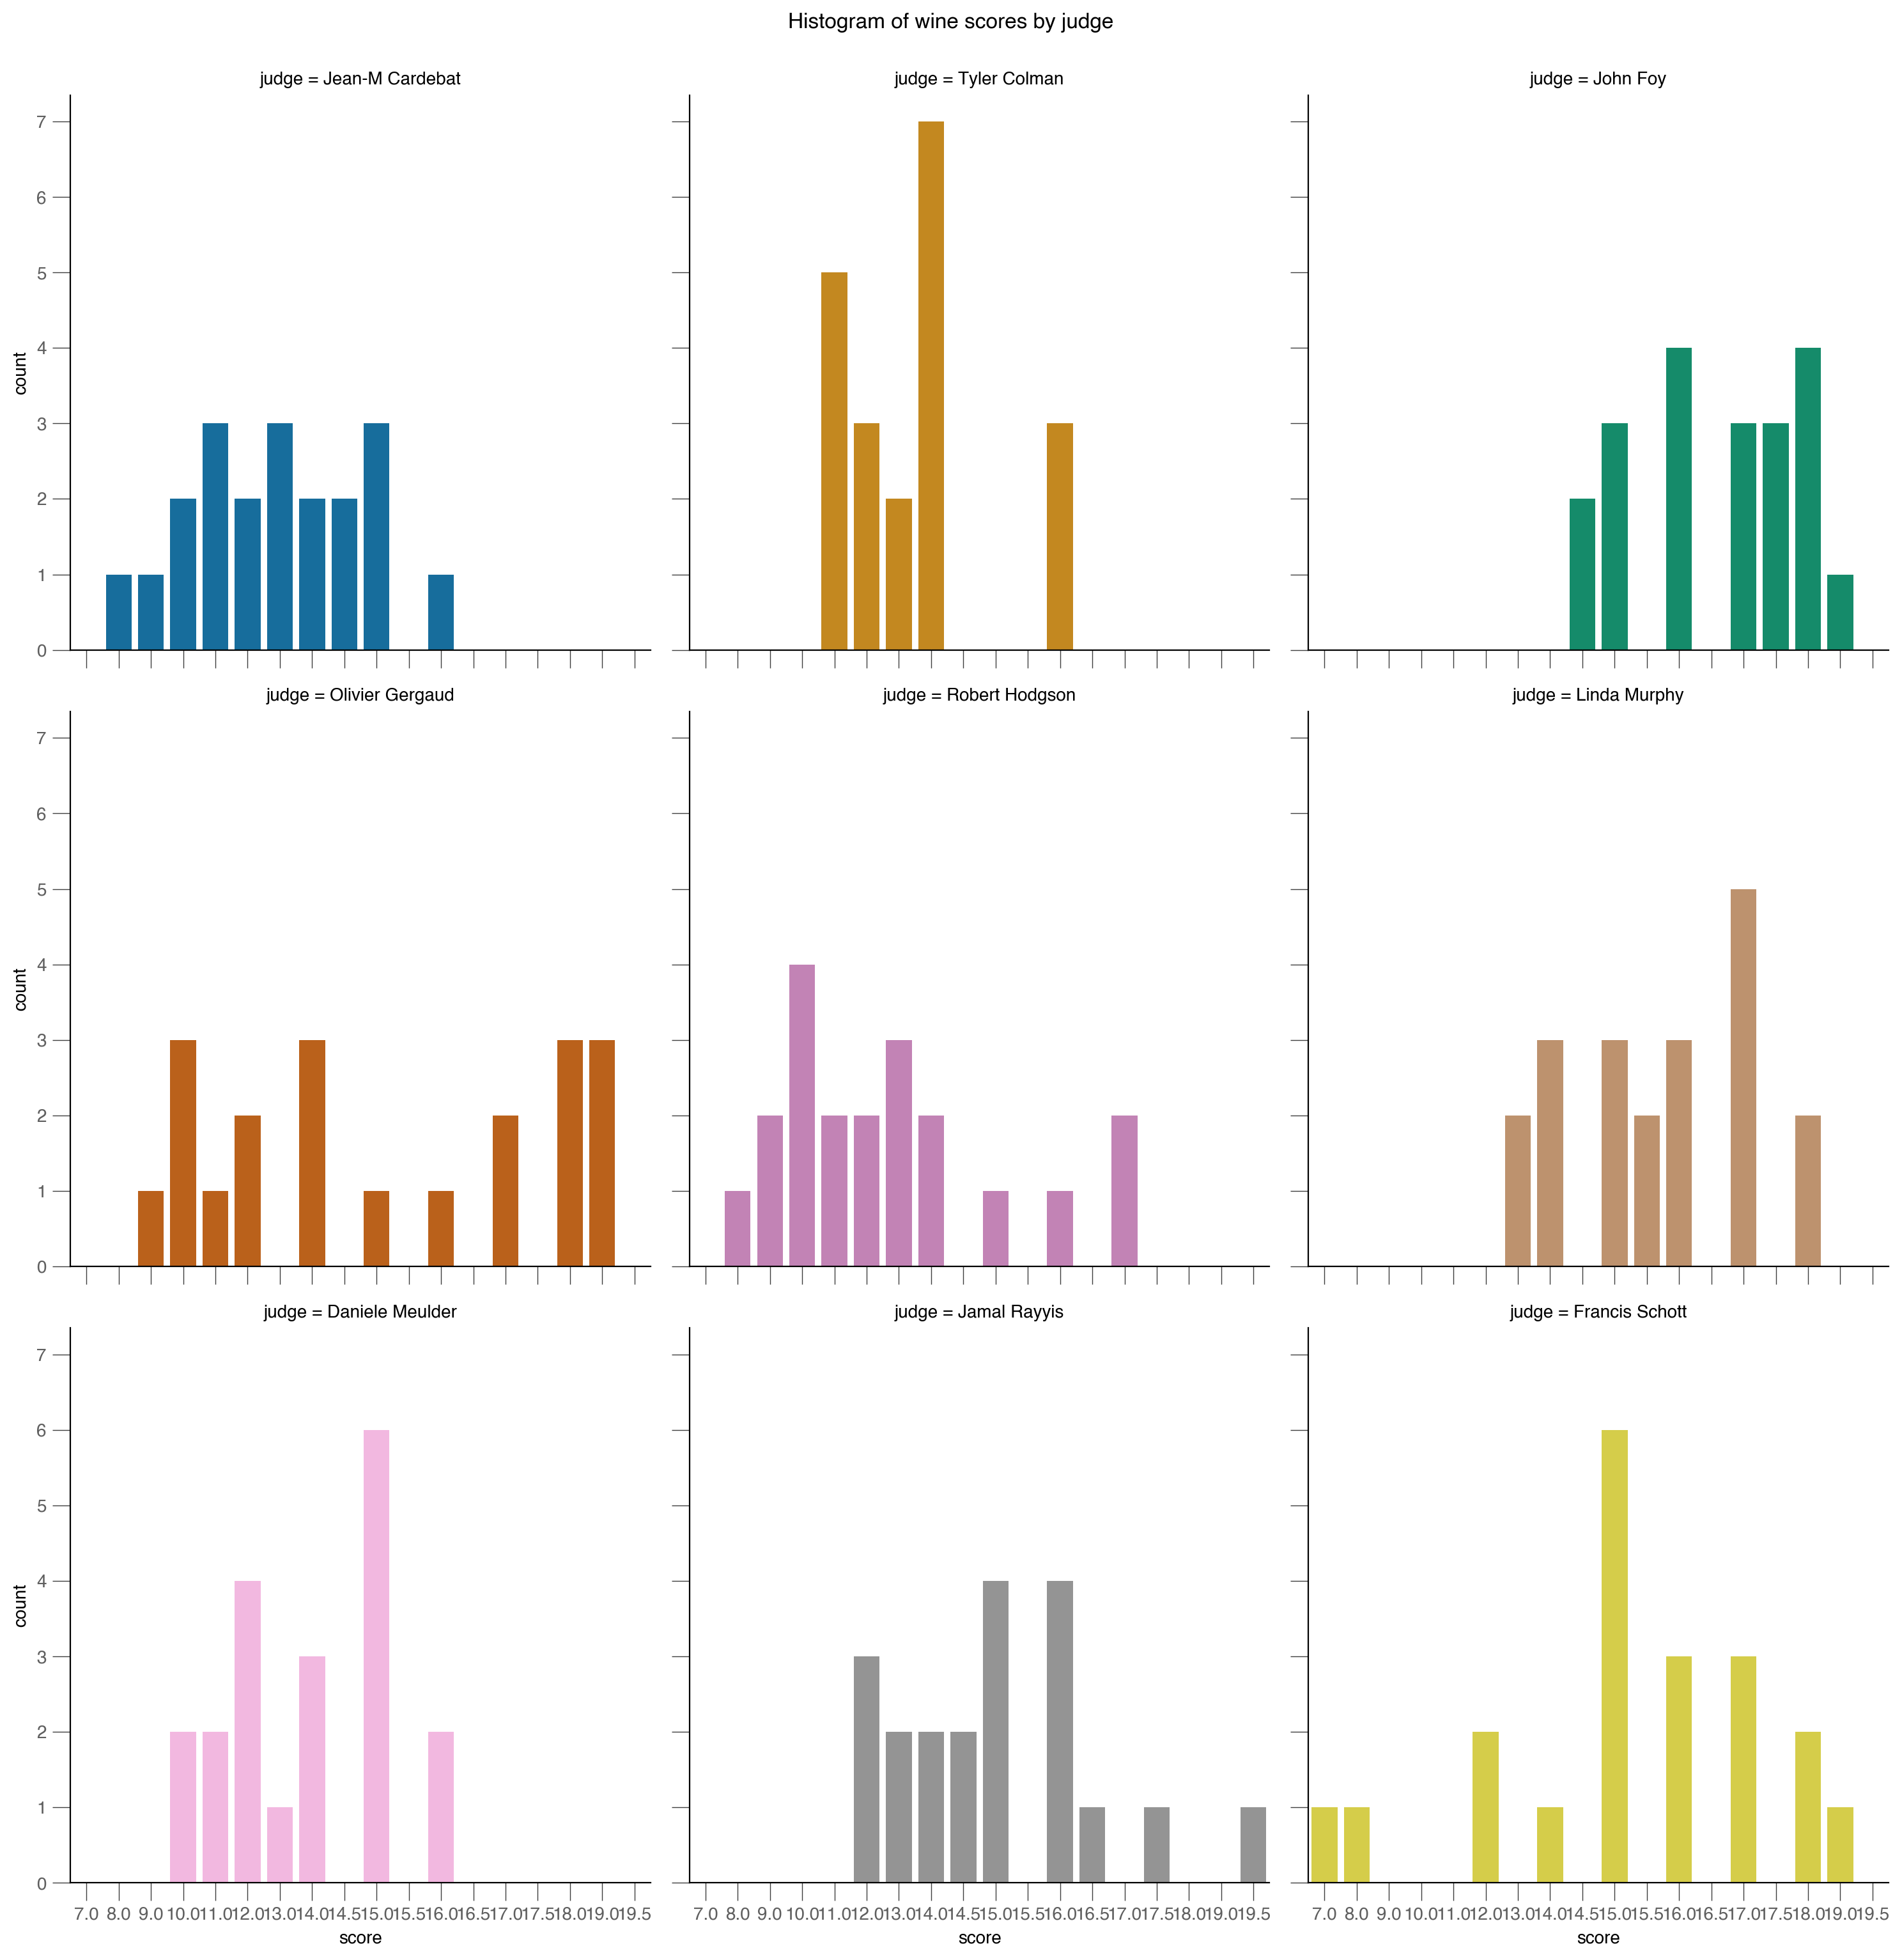

In [11]:
g = sns.catplot(
    x="score",
    data=wines,
    col="judge",
    hue="judge",
    kind="count",
    dodge=False,
    col_wrap=3,
)
g.fig.suptitle("Histogram of wine scores by judge", y=1.02);

Queste due righe calcolano il numero di giudici e il numero totale di campioni di vino presenti nel dataset.

In [9]:
n_judges = J.nunique()
n_samples = len(J)

Le coordinate sono utilizzate per dare un significato alle dimensioni dei dati e ai parametri nel modello. In questo caso, sono definite due coordinate:

`judges`: Questo array rappresenta i giudici, con una lunghezza pari al numero di giudici.
`obs`: Questo array rappresenta i singoli campioni di vino, con una lunghezza pari al numero totale di campioni.

In [10]:
COORDS = {
    "judges": np.arange(n_judges),
    "obs": np.arange(n_samples)
}

In [17]:
print(COORDS)

{'judges': array([0, 1, 2, 3, 4, 5, 6, 7, 8]), 'obs': array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169

Scriviamo il modello in PyMC.

In [11]:
with pm.Model(coords=COORDS) as wine_m:
    S = scale(wines["score"])
    J_codes = wines["judge"].astype("category").cat.codes

    sigma = pm.Exponential("sigma", 1)
    Q = pm.Normal("Q", 0, 1, dims="judges")
    mu = Q[J_codes]
    S_obs = pm.Normal("S", mu, sigma, observed=S, dims="obs")

In [19]:
wine_m

sigma ~ Exponential(f())
    Q ~ Normal(0, 1)
    S ~ Normal(f(Q), sigma)

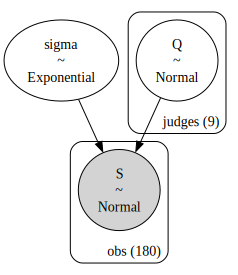

In [20]:
pm.model_to_graphviz(wine_m)

Eseguiamo il campionamento.

In [12]:
with wine_m:
    idata = pm.sampling_jax.sample_numpyro_nuts(idata_kwargs={"log_likelihood": True})

Compiling...
Compilation time =  0:00:01.227985
Sampling...


Compiling.. :   0%|          | 0/2000 [00:00<?, ?it/s]








Running chain 3: 100%|██████████| 2000/2000 [00:03<00:00, 665.03it/s]


Sampling time =  0:00:04.029438
Transforming variables...
Transformation time =  0:00:00.024933
Computing Log Likelihood...
Log Likelihood time =  0:00:00.430507


Esaminiamo le distribuzioni a posteriori dei parametri del modello.

In [22]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Q[0],-0.309,0.186,-0.662,0.043,0.002,0.002,7517.0,2701.0,1.0
Q[1],0.237,0.195,-0.135,0.592,0.002,0.002,8700.0,2890.0,1.0
Q[2],0.227,0.196,-0.138,0.601,0.002,0.002,7901.0,3303.0,1.0
Q[3],-0.597,0.191,-0.948,-0.239,0.002,0.002,9244.0,3376.0,1.0
Q[4],0.877,0.185,0.533,1.215,0.002,0.002,6887.0,2995.0,1.0
Q[5],0.528,0.193,0.176,0.897,0.002,0.002,7782.0,3105.0,1.0
Q[6],0.141,0.194,-0.212,0.511,0.002,0.003,8616.0,2925.0,1.0
Q[7],-0.726,0.200,-1.085,-0.343,0.002,0.002,8330.0,2976.0,1.0
Q[8],-0.382,0.189,-0.752,-0.053,0.002,0.002,7468.0,3266.0,1.0
sigma,0.877,0.048,0.792,0.969,0.001,0.000,6672.0,3470.0,1.0


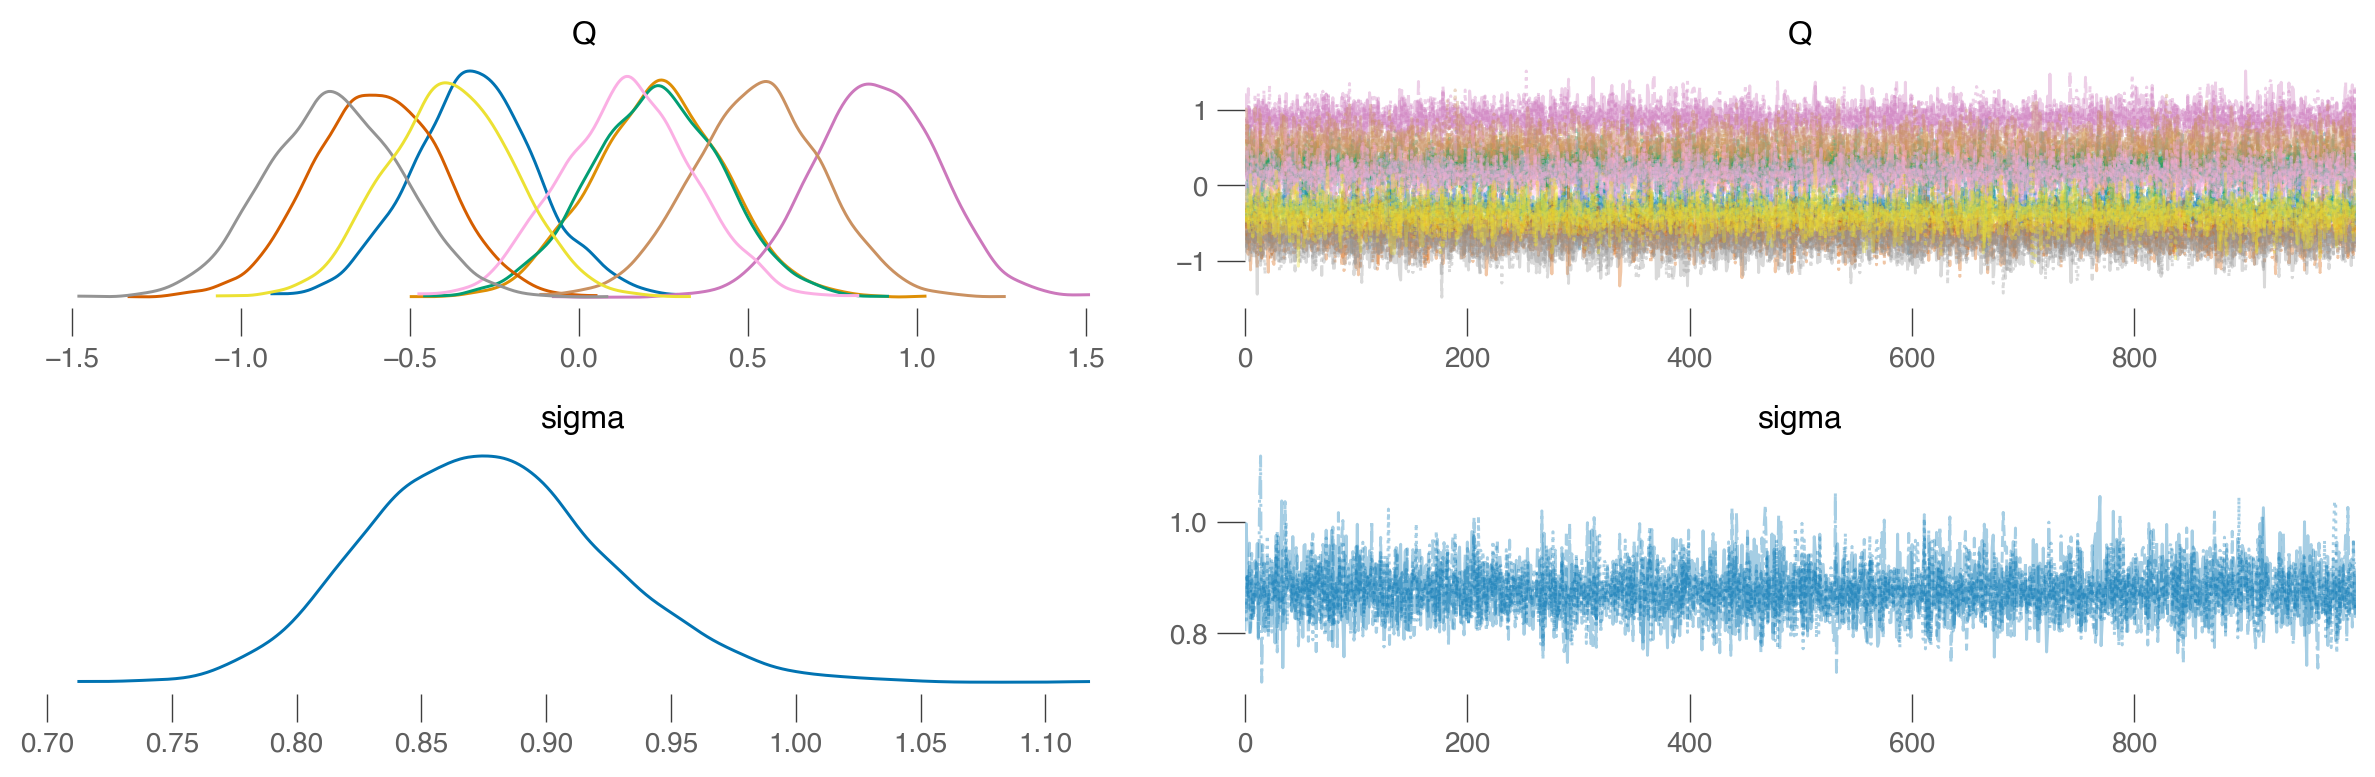

In [23]:
az.plot_trace(idata, combined=True)
plt.tight_layout();

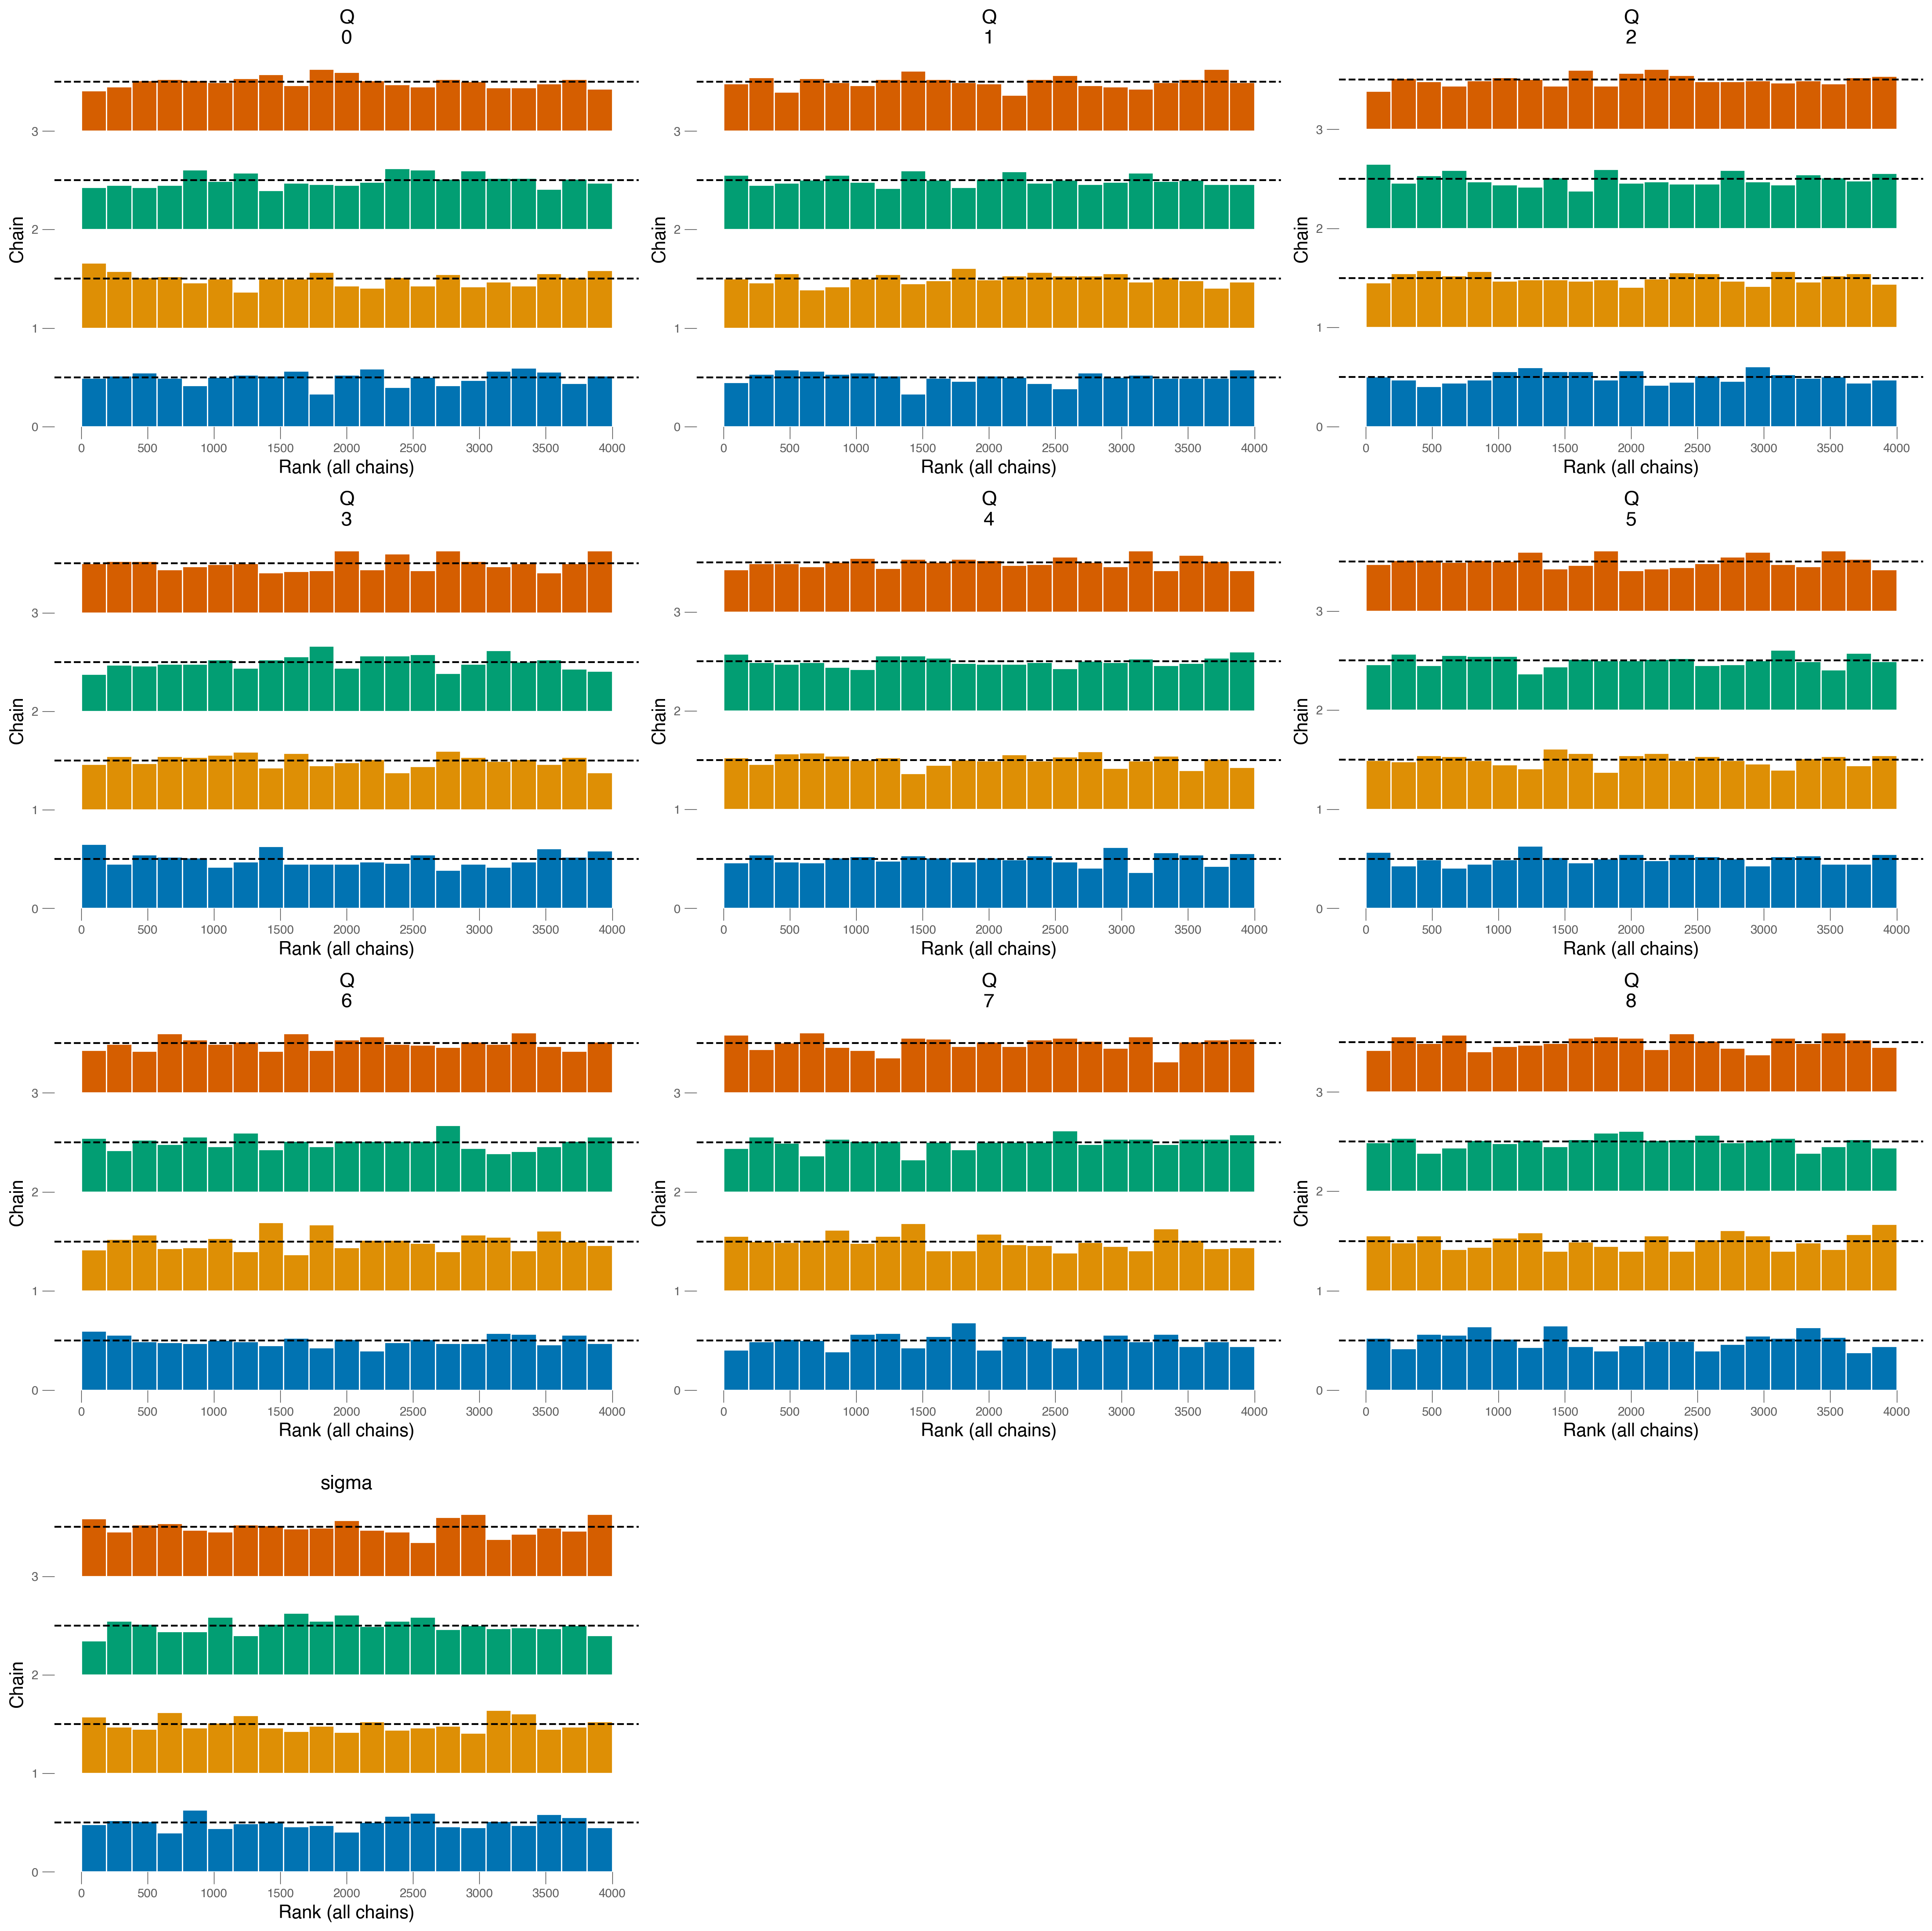

In [14]:
az.plot_rank(idata)
plt.tight_layout();

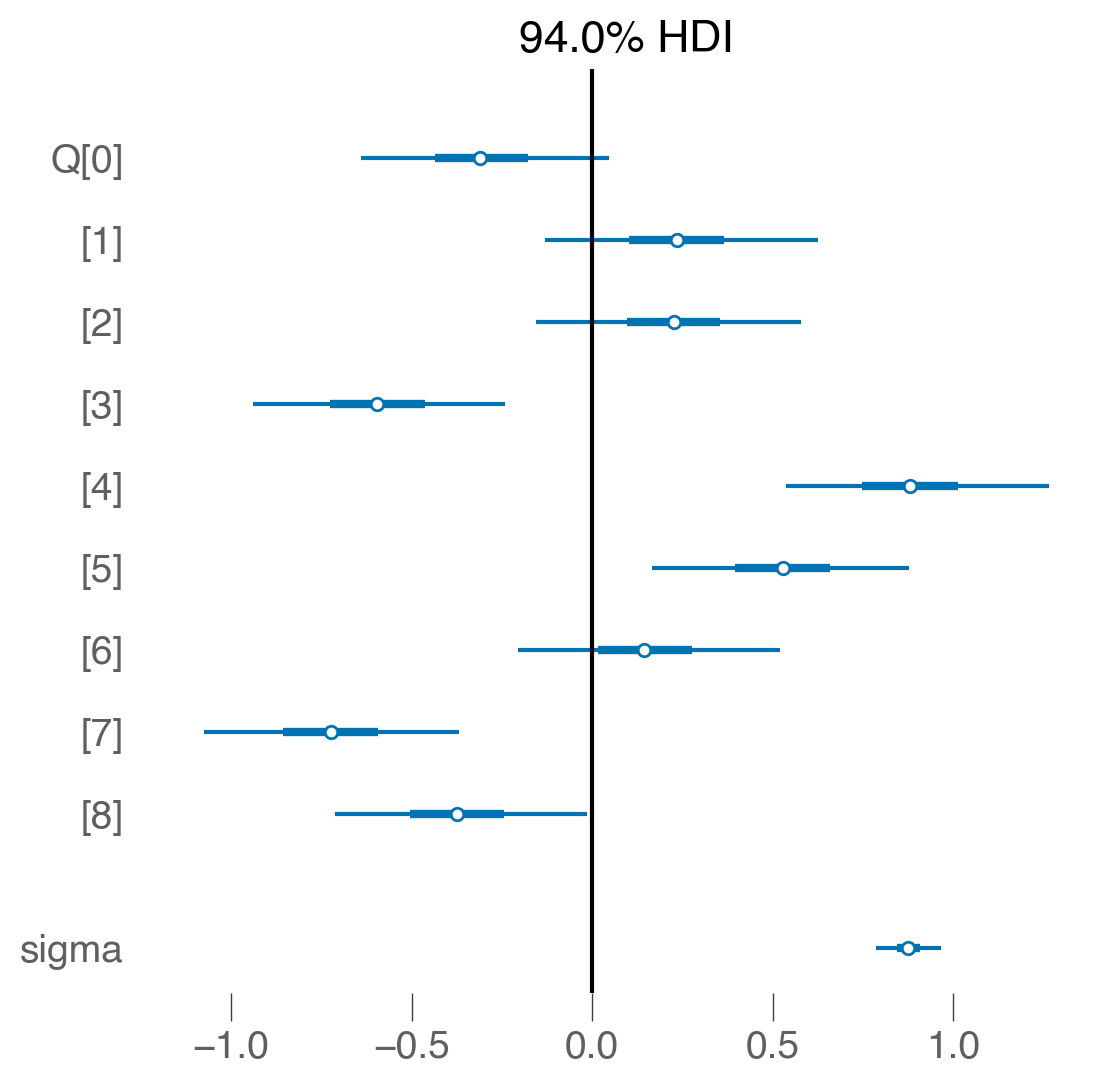

In [15]:
az.plot_forest(idata,combined=True)
plt.axvline(x = 0, color = 'black');

Si noti che c'è una notevole differenza tra i giudizi medi forniti dai diversi giudici. Il modello gerarchico tiene conto delle differenze tra questi ragruppamenti di osservazioni. In particolare, i giudici indicizzati con 3 e 7 forniscono i giudizi più bassi e i giudici indicizzati con 4 e 5 forniscono i giudizi più alti.

Consideriamo ora il posterior preditive chceck.

In [26]:
with wine_m:
    post_pred = pm.sample_posterior_predictive(idata)

Sampling: [S]


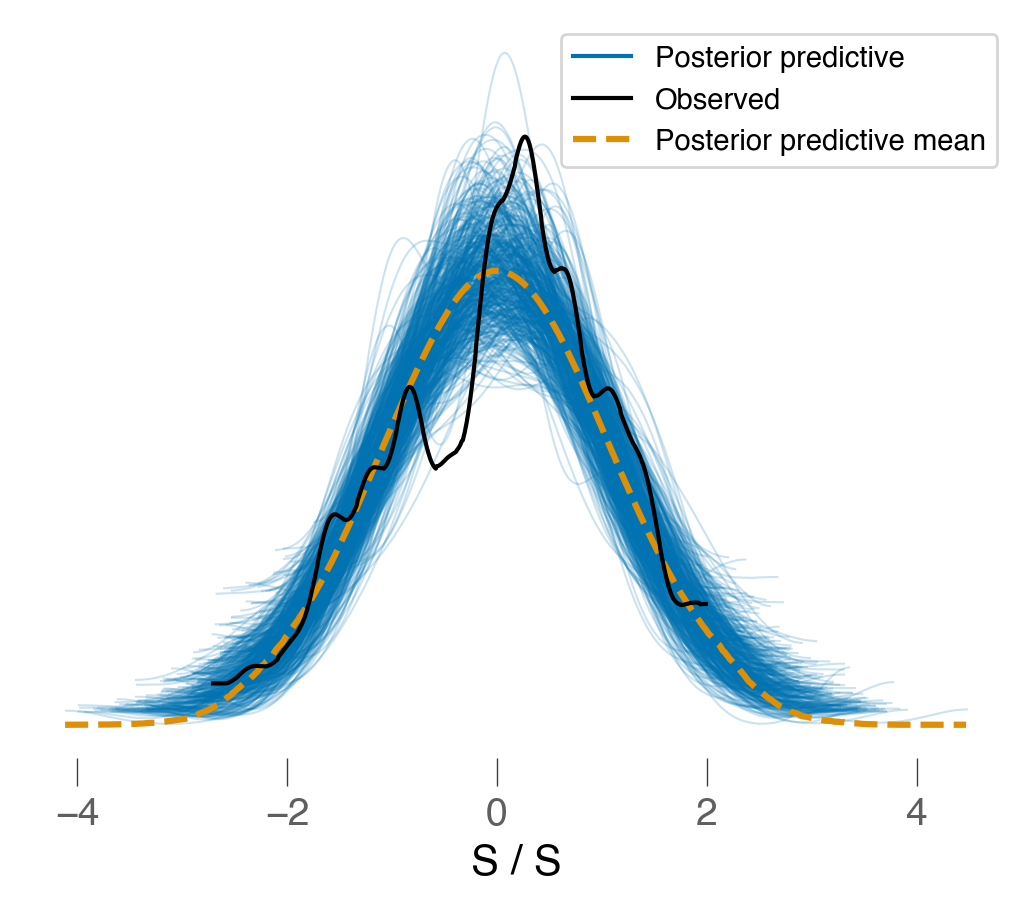

In [27]:
az.plot_ppc(post_pred, num_pp_samples=500);

L'adattamento del modello ai dati è molto buono.

Calcoliamo la Expected Log Predictive Density (ELPD) e la diagnostica Pareto $k$.

In [28]:
m_loo = az.loo(idata)
m_loo

Computed from 4000 posterior samples and 180 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -236.50    10.38
p_loo        9.64        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      180  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

La metrica diagnostica Pareto $k$ non indica la presenza di valori anomali o outliers nel set di dati.

Consideriamo ora un'analisi bayesiana che ignora la struttura gerarchica dei dati.

In [29]:
with pm.Model() as wine_m1:
    S = scale(wines["score"])

    # Prior for standard deviation of scores
    sigma = pm.Exponential("sigma", 1)

    # Prior for mean of scores (not dependent on wine categories)
    mu = pm.Normal("mu", 0, 1)

    # Likelihood
    S_obs = pm.Normal("S", mu, sigma, observed=S)

In [30]:
with wine_m1:
    idata1 = pm.sampling_jax.sample_numpyro_nuts(idata_kwargs={"log_likelihood": True})

Compiling...
Compilation time =  0:00:00.758190
Sampling...


Compiling.. :   0%|          | 0/2000 [00:00<?, ?it/s]








Running chain 3: 100%|██████████| 2000/2000 [00:03<00:00, 605.24it/s]


Sampling time =  0:00:03.454183
Transforming variables...
Transformation time =  0:00:00.008936
Computing Log Likelihood...
Log Likelihood time =  0:00:00.121068


Calcoliamo anche in questo caso la Expected Log Predictive Density (ELPD).

In [31]:
loo1 = az.loo(idata1)
loo1

Computed from 4000 posterior samples and 180 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -257.32     8.39
p_loo        1.79        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      180  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

Effettuiamo un confronto tra di due modelli considerando la differenza in ELPD.

In [32]:
df_comp_loo = az.compare({"m1": idata1, "m0": idata})
df_comp_loo

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
m0,0,-236.495243,9.642921,0.000000,0.933952,10.375323,0.000000,False,log
m1,1,-257.315908,1.787449,20.820665,0.066048,8.385248,6.551194,False,log


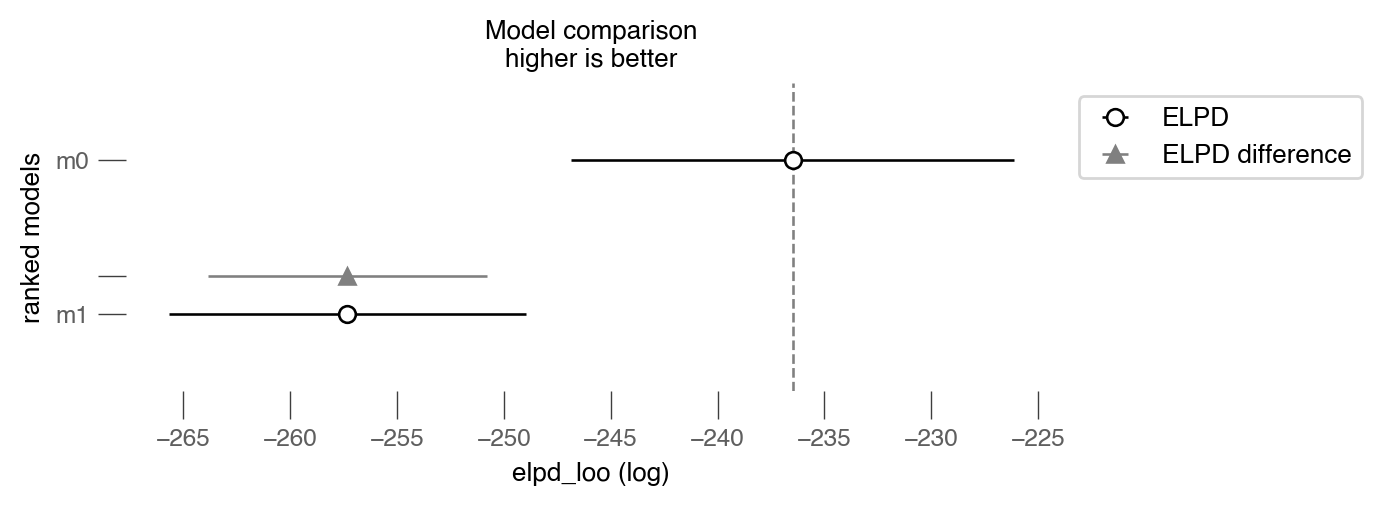

In [197]:
az.plot_compare(df_comp_loo, insample_dev=False);

La differenza nei valori di ELPD è di 20.8, con un errore standard associato alla differenza di 6.55. Il rapporto tra la differenza ELPD e il suo errore standard è superiore a 3, indicando una credibile differenza tra i due modelli. Sulla base di questi risultati statistici, possiamo concludere che il modello gerarchico offre una migliore aderenza ai dati rispetto al modello non gerarchico.

## Watermark

In [138]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor

Last updated: Fri Aug 25 2023

Python implementation: CPython
Python version       : 3.11.4
IPython version      : 8.14.0

pytensor: 2.14.2

pymc      : 5.7.2
scipy     : 1.11.2
bambi     : 0.12.0
matplotlib: 3.7.2
pandas    : 2.0.3
numpy     : 1.25.2
seaborn   : 0.12.2
arviz     : 0.16.1

Watermark: 2.4.3

